# Static Community Detection Using CDLIB, NetworkX and iGraph - M2V

After calculating similairties and updating the edge list with the values, we will look to execute the well-known Louvain using NetworkX and CDLib, Leiden using iGraph.

## Importing Edge List w/ Weights to NetworkX

NetworkX's read_weighted_edgelist function expects a simple text file with lines of the form <node1> <node2> <weight>, without headers. Since our data is in CSV format, you'll need to use Pandas (or another method) to load the CSV and adjust it to become readable.

In [1]:
import pandas as pd

edge_list_df = pd.read_csv('Input/M2V_edge_list_with_similarity.csv')

print(edge_list_df)

            source    target    weight
0        u74717431  t7748381  0.892881
1       u127821914  t3529910  0.717761
2       u174194590  t5762915  0.483259
3       u141847381  t6987845  0.720264
4        u87215499  t4082536  0.754541
...            ...       ...       ...
641138     ci20717       co3  0.772626
641139     ci20718       co9  0.878173
641140     ci20719       co5  0.737660
641141     ci20720       co3  0.751880
641142     ci20721       co4  0.766678

[641143 rows x 3 columns]


In [2]:
negative_weights = edge_list_df[edge_list_df['weight'] < 0]
print(f"Number of edges with negative weights: {len(negative_weights)}")

Number of edges with negative weights: 0


Since Louvain is not made to consider negative edge weights, we will rescale the weights such that instead of [-1, 1] being the range, it is now [0, 1], where 0 now represents perfect dissimilarity, 0.5 represents orthogonality, and 1 represents perfect similarity.

In [3]:
edge_list_df['weight'] = (edge_list_df['weight'] + 1) / 2

print(edge_list_df)

            source    target    weight
0        u74717431  t7748381  0.946440
1       u127821914  t3529910  0.858880
2       u174194590  t5762915  0.741629
3       u141847381  t6987845  0.860132
4        u87215499  t4082536  0.877271
...            ...       ...       ...
641138     ci20717       co3  0.886313
641139     ci20718       co9  0.939086
641140     ci20719       co5  0.868830
641141     ci20720       co3  0.875940
641142     ci20721       co4  0.883339

[641143 rows x 3 columns]


Before we continue with the creation of a graph, NetworkX specifies that an undirected, weighted graph must not have self-loop, parallel edges (A->B, B->A), or duplicate edges.

In [4]:
duplicate_edges = edge_list_df.duplicated(subset=['source', 'target'], keep=False)
print(f"Number of duplicate edges: {duplicate_edges.sum()}")

self_loops = edge_list_df[edge_list_df['source'] == edge_list_df['target']]
print(f"Number of self-loops: {len(self_loops)}")

print(edge_list_df.isnull().sum())

Number of duplicate edges: 0
Number of self-loops: 0
source    0
target    0
weight    0
dtype: int64


In [5]:
# Find duplicate edges (ignoring the weight column)
duplicate_edges = edge_list_df.duplicated(subset=['source', 'target'], keep=False)

# Filter to get only the duplicate edges
parallel_edges_df = edge_list_df[duplicate_edges]

# Sort to better visualize parallel edges
parallel_edges_sorted = parallel_edges_df.sort_values(by=['source', 'target'])

print(parallel_edges_sorted)

Empty DataFrame
Columns: [source, target, weight]
Index: []


We check for any non-numeric values in the weight column, since this will not be valid when input into a graph object.

In [6]:
# Check for any non-numeric values in the 'weight' column
non_numeric_weights = edge_list_df[pd.to_numeric(edge_list_df['weight'], errors='coerce').isna()]

# Display rows with non-numeric or NaN weights
print(non_numeric_weights)

Empty DataFrame
Columns: [source, target, weight]
Index: []


In [7]:
# Convert the 'weight' column to floating point values
edge_list_df['weight'] = edge_list_df['weight'].astype(float)

# Check the data type of the column to confirm the conversion
print(edge_list_df.dtypes)

source     object
target     object
weight    float64
dtype: object


## Creating Undirected Weighted Graph

We iterate over the edge list DataFrame rows to add edges along with their weights to a new NetworkX graph.


In [8]:
import networkx as nx

def get_graph_info(graph):
    print("Number of nodes:", graph.number_of_nodes())
    print("Number of edges:", graph.number_of_edges())
    
    # Checking the graph type to provide appropriate information
    if isinstance(graph, nx.DiGraph):
        print("Graph is Directed")
    else:
        print("Graph is Undirected")


In [9]:
# Initialize a new graph
G = nx.MultiGraph()

# Add edges and weights
for index, row in edge_list_df.iterrows():
    source = row['source']
    target = row['target']
    weight = row['weight']
    
    # Add the edge with weight
    G.add_edge(source, target, weight=weight)

In [10]:
get_graph_info(G)

Number of nodes: 245621
Number of edges: 641143
Graph is Undirected


## Running Louvain Using CDLIB + NX

CDlib (Community Discovery Library) is designed for community detection and analysis, providing easy access to various algorithms, including Louvain and Leiden, and tools for evaluating and visualizing the results.

In [11]:
from cdlib import algorithms


Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'bayanpy', 'wurlitzer', 'graph_tool'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


In [12]:
communities_louvain = algorithms.louvain(G)

# Accessing the number of communities/partitions
num_partitions = len(communities_louvain.communities)
print(f"Number of partitions: {num_partitions}")

# Accessing modularity
modularity = communities_louvain.newman_girvan_modularity().score
print(f"Modularity: {modularity}")

Number of partitions: 275
Modularity: 0.7102853762876724


## Creating Undirected Weighted iGraph for Leiden

Provided that running Leiden on the MusicMicro dataset was problematic, we decided to isolate the issue and directly use iGraph, as suggested by Leiden's authors.  

We iterate over the edge list DataFrame rows to add edges into a tuple list, along with their weights in a separate list for input into a new iGraph graph.

In [13]:
import igraph as ig

# Assuming edge_list_df is your DataFrame
edges_with_weights = [(row['source'], row['target'], row['weight']) for index, row in edge_list_df.iterrows()]

# Creating the igraph Graph
g = ig.Graph.TupleList(edges_with_weights, edge_attrs={'weight': [w for _, _, w in edges_with_weights]})

# Now, check again if the weights have been correctly assigned
print(g.es['weight'][:5])
print(g.summary())

[0.9464404929422645, 0.8588802696312696, 0.7416292808281564, 0.8601320326015599, 0.8772707346584033]
IGRAPH UNW- 245621 641143 -- 
+ attr: name (v), weight (e)


## Running Leiden Using iGraph + leidenalg

In [14]:
import leidenalg

# Run the Leiden algorithm
partition = leidenalg.find_partition(g, partition_type=leidenalg.ModularityVertexPartition, weights='weight')

# Extract the number of communities
num_communities = len(partition)

# Calculate the modularity score
modularity = partition.modularity

print(f"Number of partitions: {num_communities}")
print(f"Modularity score: {modularity}")

Number of partitions: 257
Modularity score: 0.6063917184482205


## Saving Node List w/ Community Assignments

In order for us to visualize the partitions, we need to iterate through each partition and assign an ID to every node in it. This way we can color code when visualizing to see which nodes were assigned together. 

### Load Node ID List

This was copied from Similar+Weights folder.

In [15]:
# Load node IDs into a DataFrame
node_df = pd.read_csv('Input/M2V_node_indexes.txt', header=None, names=['nodeID'])

# Remove underscores from the 'nodeID' column while keeping the prefix letter
node_df['nodeID'] = node_df['nodeID'].str.replace('_', '', regex=True)

display(node_df)

,nodeID
0,co3
1,u174194590
2,ci17
3,ci5
4,co4
...,...
245616,t5141917
245617,a200804
245618,a172658
245619,a379402


In [16]:
def get_type(node_id):
    if node_id.startswith('t'):
        return 'track'
    elif node_id.startswith('a'):
        return 'artist'
    elif node_id.startswith('u'):
        return 'user'
    elif node_id.startswith('ci'):
        return 'city'
    elif node_id.startswith('co'):
        return 'country'
    else:
        return 'unknown'

node_df['type'] = node_df['nodeID'].apply(get_type)

display(node_df)

,nodeID,type
0,co3,country
1,u174194590,user
2,ci17,city
3,ci5,city
4,co4,country
...,...,...
245616,t5141917,track
245617,a200804,artist
245618,a172658,artist
245619,a379402,artist


In [17]:
import matplotlib.cm as cm
import matplotlib

### For Louvain

In [18]:
# Correctly accessing the communities for iteration
n_communities = len(communities_louvain.communities)
colors = cm.get_cmap('viridis', n_communities)

# Initialize the mapping dictionary
node_community_color_map = {}

for community_id, community_nodes in enumerate(communities_louvain.communities):
    color = colors(community_id / n_communities)  # Get a color from the colormap
    color_hex = matplotlib.colors.rgb2hex(color)  # Convert the color to hex format
    
    for node in community_nodes:
        node_community_color_map[str(node)] = {"communityID": community_id, "color": color_hex}

In [19]:
node_df_louvain = node_df.copy()

# Add community ID, color, and type to the DataFrame
node_df_louvain['communityID'] = node_df['nodeID'].apply(lambda x: node_community_color_map[x]['communityID'] if x in node_community_color_map else -1)
node_df_louvain['color'] = node_df['nodeID'].apply(lambda x: node_community_color_map[x]['color'] if x in node_community_color_map else '#000000')

display(node_df_louvain)

,nodeID,type,communityID,color
0,co3,country,4,#450559
1,u174194590,user,3,#450457
2,ci17,city,2,#440256
3,ci5,city,1,#440154
4,co4,country,5,#46075a
...,...,...,...,...
245616,t5141917,track,49,#433d84
245617,a200804,artist,1,#440154
245618,a172658,artist,6,#46085c
245619,a379402,artist,1,#440154


In [20]:
# Select relevant columns if necessary and export to CSV
node_df_louvain[['nodeID', 'communityID', 'color', 'type']].to_csv('Output/node_metadata_M2V_Louvain.csv', index=False, sep=';')

### For Leiden

In [21]:
# Correctly accessing the communities for iteration with Leiden results
n_communities = len(partition)
colors = cm.get_cmap('viridis', n_communities)

# Initialize the mapping dictionary for Leiden communities
node_community_color_map = {}

# Mapping nodes to communities and colors
for community_id, community_nodes in enumerate(partition):
    color = colors(community_id / n_communities)  # Get a color from the colormap
    color_hex = matplotlib.colors.rgb2hex(color)  # Convert the color to hex format
    
    for node in community_nodes:
        node_community_color_map[str(g.vs[node]['name'])] = {"communityID": community_id, "color": color_hex}

In [22]:
node_df_leiden = node_df.copy()

# Add community ID and color to the DataFrame based on Leiden results
node_df_leiden['communityID'] = node_df['nodeID'].apply(lambda x: node_community_color_map[x]['communityID'] if x in node_community_color_map else -1)
node_df_leiden['color'] = node_df['nodeID'].apply(lambda x: node_community_color_map[x]['color'] if x in node_community_color_map else '#000000')

# Display the updated DataFrame
display(node_df_leiden)

,nodeID,type,communityID,color
0,co3,country,4,#46075a
1,u174194590,user,3,#450559
2,ci17,city,1,#440256
3,ci5,city,2,#450457
4,co4,country,6,#460a5d
...,...,...,...,...
245616,t5141917,track,43,#443a83
245617,a200804,artist,2,#450457
245618,a172658,artist,5,#46085c
245619,a379402,artist,9,#470e61


In [23]:
# Select relevant columns if necessary and export to CSV
node_df_leiden[['nodeID', 'communityID', 'color', 'type']].to_csv('Output/node_metadata_M2V_Leiden.csv', index=False, sep=';')

## Exploring Community Assignments

We would also like to explore the difference in communities between Leiden and Louvain, check whether they make sense by looking at their content, and investigate why Leiden produces significantly less communities in comparison to Louvain.

### Import Original Node Information

First, we import the original dataset information including track, artist, city, country names. This way we can manually check if the assignment makes sense, by looking at the actual content of its nodes.

In [24]:
tracks_df = pd.read_csv('Extra Input/track_mapping.txt', sep='\t', encoding='ISO-8859-1')
artists_df = pd.read_csv('Extra Input/artist_mapping.txt', sep='\t')
cities_df = pd.read_csv('Extra Input/city_mapping.txt', sep='\t')
countries_df = pd.read_csv('Extra Input/country_mapping.txt', sep='\t')

display(tracks_df)
display(artists_df)
display(cities_df)
display(countries_df)

,track-id,track
0,1692316,Avec le temps
1,8030594,Wild Night
2,1201495,Le plus beau du quartier
3,6129176,Probably a Robbery
4,9474108,Sadness Is a Blessing
...,...,...
71405,8535638,Bebas
71406,8276352,Rondo
71407,6118830,Levemente
71408,68841,Running With the Light


,artist-id,artist
0,450514,Tihuana
1,202085,James Morrison
2,330061,Pet Shop Boys
3,404350,Suede
4,227460,Kaskade
...,...,...
19524,190059,ILYA
19525,287958,Milla Jovovich
19526,269025,Manu Dibango
19527,340887,Prolyphic & Reanimator


,city-id,city
0,0,Quirinópolis
1,1,Setiabudi
2,2,London
3,3,Dramaga
4,4,New York
...,...,...
20717,20717,Kenbridge
20718,20718,Tire
20719,20719,Pitt Meadows
20720,20720,Lindale


,country-id,country
0,0,Brazil
1,1,Indonesia
2,2,United Kingdom
3,3,United States
4,4,France
...,...,...
175,175,Mayotte
176,176,Ethiopia
177,177,French Polynesia
178,178,Saint Kitts and Nevis


To add the names of tags and artists to our main dataframes, we create dictionaries that help us directly map ID to name. We also define a function that adds the corresponding name to a new column based on the ID.

In [35]:
track_dict = pd.Series(tracks_df['track'].values, index=tracks_df['track-id'].apply(lambda x: f't{x}')).to_dict()
artist_dict = pd.Series(artists_df['artist'].values, index=artists_df['artist-id'].apply(lambda x: f'a{x}')).to_dict()
city_dict = pd.Series(cities_df['city'].values, index=cities_df['city-id'].apply(lambda x: f'ci{x}')).to_dict()
country_dict = pd.Series(countries_df['country'].values, index=countries_df['country-id'].apply(lambda x: f'co{x}')).to_dict()


def id_to_name(node_id):
    if node_id.startswith('t'):
        return track_dict.get(node_id, "Unknown Track")
    elif node_id.startswith('a'):
        return artist_dict.get(node_id, "Unknown Artist")
    elif node_id.startswith('ci'):
        return city_dict.get(node_id, "Unknown City")
    elif node_id.startswith('co'):
        return country_dict.get(node_id, "Unknown Country")
    elif node_id.startswith('u'):
        # Adjust if you have a user dictionary
        return "User"  # Or user_dict.get(node_id, "Unknown User") if you have user names
    else:
        return "Invalid prefix"




In [36]:
node_df_louvain['name'] = node_df_louvain['nodeID'].apply(id_to_name)
node_df_leiden['name'] = node_df_leiden['nodeID'].apply(id_to_name)


In [37]:
display(node_df_louvain)
display(node_df_leiden)

,nodeID,type,communityID,color,name
0,co3,country,4,#450559,United States
1,u174194590,user,3,#450457,User
2,ci17,city,2,#440256,Gambir
3,ci5,city,1,#440154,Diadema
4,co4,country,5,#46075a,France
...,...,...,...,...,...
245616,t5141917,track,49,#433d84,How Low the Barrel
245617,a200804,artist,1,#440154,Jah Live
245618,a172658,artist,6,#46085c,Grupo marrano
245619,a379402,artist,1,#440154,Shane Alexander


,nodeID,type,communityID,color,name
0,co3,country,4,#46075a,United States
1,u174194590,user,3,#450559,User
2,ci17,city,1,#440256,Gambir
3,ci5,city,2,#450457,Diadema
4,co4,country,6,#460a5d,France
...,...,...,...,...,...
245616,t5141917,track,43,#443a83,How Low the Barrel
245617,a200804,artist,2,#450457,Jah Live
245618,a172658,artist,5,#46085c,Grupo marrano
245619,a379402,artist,9,#470e61,Shane Alexander


### **For Louvain**

#### Overview of Community Data

First, we aggregate the data by community ID to get an overview of each community's composition. We group our DataFrame by the community ID and then examine the types and names within each community.


In [38]:
# Group by community ID and list out members of each community
community_groups_louvain = node_df_louvain.groupby('communityID')

# Example to print out the composition of each community
for community_id, group in community_groups_louvain:
    print(f"Community ID: {community_id}")
    print(f"Members count: {len(group)}")
    print(group[['nodeID', 'name', 'type']].head())  # Adjust as needed
    print("\n")

Community ID: 0
Members count: 46708
     nodeID          name    type
9   a122991         Drake  artist
13    ci156  Philadelphia    city
22    ci470       Chicago    city
24    ci229       Houston    city
32    ci323    Washington    city


Community ID: 1
Members count: 42771
     nodeID              name    type
3       ci5           Diadema    city
11     ci50    Rio De Janeiro    city
15  t141574  Someone Like You   track
16  a356772           Rihanna  artist
18   a82745          Coldplay  artist


Community ID: 2
Members count: 27562
   nodeID                 name     type
2    ci17               Gambir     city
5    ci29  Bandar Kuala Lumpur     city
10    co1            Indonesia  country
23  ci114        Bandung Wetan     city
25   ci53        Sukomanunggal     city


Community ID: 3
Members count: 18699
         nodeID         name    type
1    u174194590         User    user
81    u23573258         User    user
109     a419217  The Beatles  artist
136       ci120   Manchest

In [39]:
community_summary_louvain = node_df_louvain.groupby('communityID')['type'].value_counts().unstack(fill_value=0)

# Calculate the total number of entities in each community
community_summary_louvain['total_entities'] = community_summary_louvain.sum(axis=1)

# Reset the index to turn the index into a column
community_summary_louvain.reset_index(inplace=True)

# Display the summary table
community_summary_louvain

type,communityID,artist,city,country,track,user,total_entities
0,0,1144,2383,5,7992,35184,46708
1,1,1990,923,0,12145,27713,42771
2,2,803,1562,10,4133,21054,27562
3,3,3508,297,1,11823,3070,18699
4,4,529,2847,6,2295,6790,12467
...,...,...,...,...,...,...,...
270,270,1,0,0,1,1,3
271,271,1,0,0,1,1,3
272,272,0,1,1,0,1,3
273,273,1,0,0,1,1,3


#### Community Sizes

If we want to explore how the Louvain conducted its partitions, we can also review the sizes of the communities by:
- Normal histogram showing distirbution of size amongst communities, however, this isn't too clear.
- Box Plot could show where the majhority of communities exist in terms of size, and whether there are many outliers.
- A closer look at the 20 largest communities gives us an idea of their size.
- Pie Chart with a categorization of communities in small, medium and large.

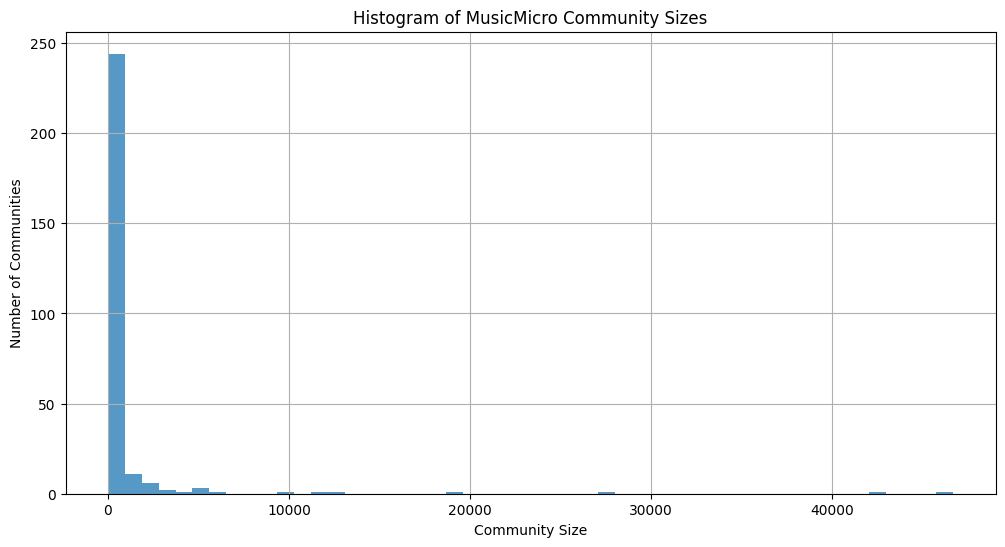

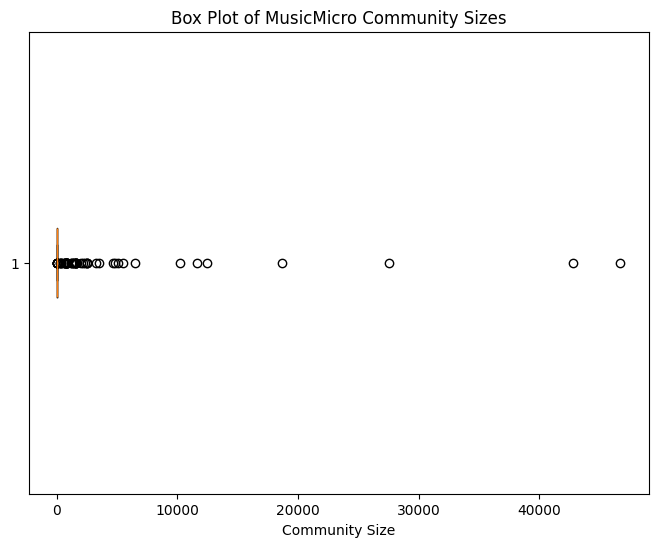

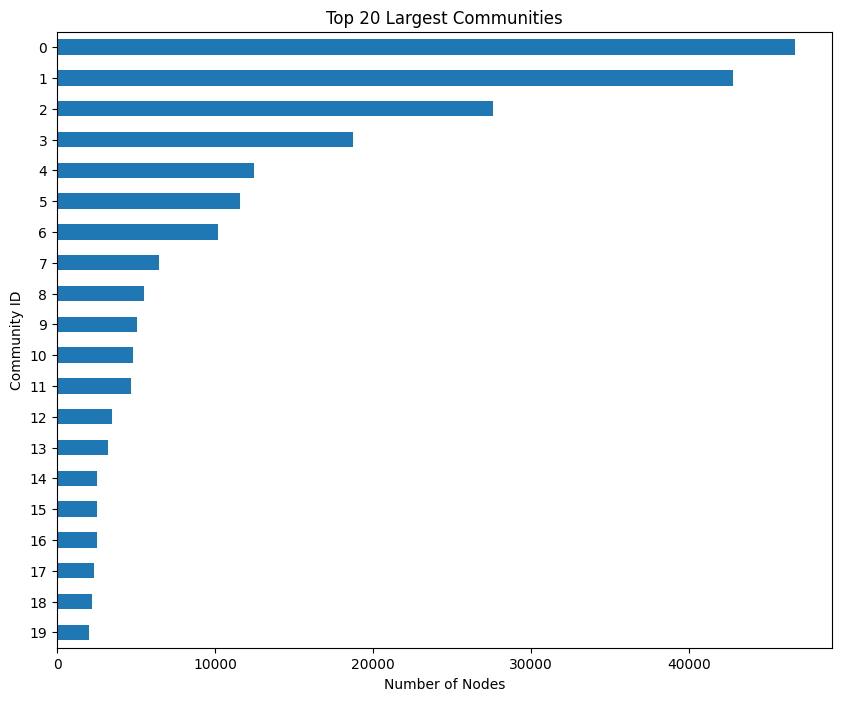

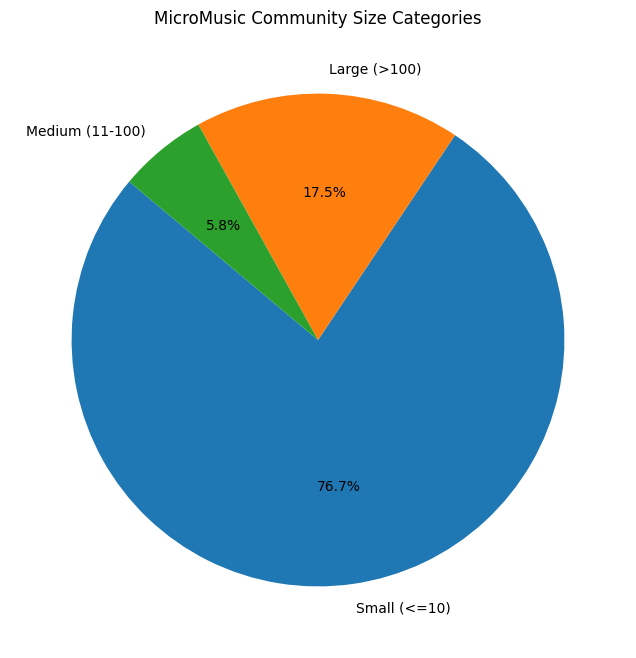

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the size of each community
community_sizes_louvain = node_df_louvain.groupby('communityID').size()

# Plot a histogram
plt.figure(figsize=(12, 6))
plt.hist(community_sizes_louvain, bins=50, alpha=0.75)
plt.title('Histogram of MusicMicro Community Sizes')
plt.xlabel('Community Size')
plt.ylabel('Number of Communities')
plt.grid(True)
plt.show()

# Plot a boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(community_sizes_louvain, vert=False)
plt.title('Box Plot of MusicMicro Community Sizes')
plt.xlabel('Community Size')
plt.show()

# Plot sizes of the top N communities
top_n = 20
top_communities = community_sizes_louvain.nlargest(top_n).sort_values()
top_communities.plot(kind='barh', figsize=(10, 8))
plt.title(f'Top {top_n} Largest Communities')
plt.xlabel('Number of Nodes')
plt.ylabel('Community ID')
plt.show()

# Plot pie chart
def categorize_size(x):
    if x <= 10:
        return 'Small (<=10)'
    elif x <= 100:
        return 'Medium (11-100)'
    else:
        return 'Large (>100)'

size_categories = community_sizes_louvain.apply(categorize_size).value_counts()

size_categories.plot(kind='pie', autopct='%1.1f%%', startangle=140, figsize=(8, 8))
plt.title('MicroMusic Community Size Categories')
plt.ylabel('')  # Hide the y-label as it's not informative for a pie chart
plt.show()

#### Community Content Analysis

In order to determine if the separation of entities into communities actually makes sense, we need to look at the internal components of communities.

In [53]:
community = node_df_louvain[node_df_louvain['communityID'] == 39]
# Count the occurrence of each type within the community
print(community['type'].value_counts())
# List all unique tags or artists within the community
print("Unique countries:", community[community['type'] == 'country']['name'].unique())
print("Unique cities:", community[community['type'] == 'city']['name'].unique())
print("Unique artists:", community[community['type'] == 'artist']['name'].unique())

type
user       300
city       188
track      168
artist      39
country      3
Name: count, dtype: int64
Unique countries: ['Lebanon' 'Egypt' 'Qatar']
Unique cities: ['Madenet Naser 1' 'Doha' 'Misr El Gididaa' 'El Nozha' 'Al Rayyan'
 'Bab Sharq' 'El Maadi' 'El Dokki' 'Sidi Gaber' 'El Mansourah Qesm 2'
 'Sixth Of October Qesm 1' 'El Hamra' 'El Baouchriye' 'El Chiah'
 'Sharm El Sheikh' 'Candilichera' 'El Zaytoun' 'Markaz El Zaqazeq'
 'Bsatine El Mina' 'Ghadir' 'El Obor' 'El Ramel Qesm 1' 'Al Wakra' 'Jbail'
 'Madenet Naser 2' 'Ed Dekouane' 'Haret Sakhr' 'Dbaiyeh' 'El Agouza'
 'Sarba' 'El Hamam' 'El Zaher' 'El Qahera El Gididaa 3' 'Nagaoka-shi'
 'Baabda' 'El Qahera El Gididaa 2' 'Hurghada Qesm 1' 'Al Khor'
 'Misr El Kadima' 'El Sanayeaa' 'El Tour' 'Baabdat Es Sfayleh'
 'Haret Hreik' 'Hboub' 'Giza' 'El Khalefa' 'Tanta Qesm 2' 'El Omraniya'
 'Araya' 'Madenet El Asher Men Ramdan Qesm 1' 'Mtaileb'
 'Marina El Alameen' 'Boulak El Dakrour' 'Superior' 'El Bsateen' 'Safra'
 'Beit Meri' 'El Bachou

We can also look at the distribution of tags across communities, and whether there is a coherent thematic difference between communities. This is partial evidence for a successful detection of community structures.